In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install cinemagoer
!pip install pyLDAvis
!pip install swifter
!pip install wikipedia

import re
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import pandas as pd
import wikipedia
import numpy as np
import json
import glob
from imdb import Cinemagoer
import tqdm
import time
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
nltk.download('all')
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

### Load Data from IMDb

In [39]:
movie_title_arr = []
movie_year_arr = []
movie_genre_arr = []
image_id_arr = []
movie_synopsis_arr = []

In [40]:
ia = Cinemagoer()

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  plot = movie.get('plot')[0]
  indx = plot.find('::')
  if indx != -1:
    return plot[:indx]
  return plot

In [41]:
def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getsynopsys(id):
  try:
    movie_synopsis = getSynopsisFromImdb(id)
    return movie_synopsis
  except:
    return 'NA'

def getImageId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

In [5]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
    
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)
    movie_title_arr.append(movie_title)

    # Movie id
    id = getImageId(image)
    image_id_arr.append(id)
        
    # Movie release year
    year = getReleaseYear(header)
    movie_year_arr.append(year)

    # Movie Synopsys
    synopsis = getsynopsys(id)
    movie_synopsis_arr.append(synopsis)

    # Genre
    genre = getGenre(muted_text)
    movie_genre_arr.append(genre)
        

In [7]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [ ]:
# Maximum number of threads that will be spawned
MAX_THREADS = 6

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

# Attach all the data to the pandas dataframe. You can optionally write it to a CSV file as well
movieDf = pd.DataFrame({
    "Title": movie_title_arr,
    "Year": movie_year_arr,
    "Genre": movie_genre_arr,
    "Synopsis": movie_synopsis_arr,
    "IMDb id": image_id_arr,
})

movieDf.to_csv('israel_originated_movies_imdb.csv')

NameError: ignored

In [ ]:
movieDf

,Title,Year,Genre,Synopsis,IMDb id
0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054
1,A Story of David,1960,Drama,A woman's beach vacation takes a dark turn whe...,0054342
2,Rumpelstiltskin,1987,Drama,King Saul of Israel is jealous of the fame and...,0093891
3,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",0068694
4,Synonymes,2019,"Drama, Sport",Eitan is yesterday's football star waiting for...,7016254
...,...,...,...,...,...
1466,BaKavod Sheli,2004,Drama,NA,8317822
1467,Outcry,1998,Horror,NA,9354814
1468,Alenbi Romance,2005,"Drama, Romance","""All of those romantic movies are always in fo...",0808145
1469,Street 60,1976,"Drama, Romance",NA,5524664


In [91]:
complete_data = pd.read_csv('israel_originated_movies_imdb.csv').dropna()
complete_data = complete_data[complete_data.Year != '(III']
complete_data = complete_data[complete_data.Year != '(LX']
complete_data = complete_data[complete_data.Year != '(II']
complete_data = complete_data[complete_data.Year != '(I']
complete_data = complete_data[complete_data.Year != '(V']
complete_data = complete_data[complete_data.Year != '(VII']
complete_data = complete_data[complete_data.Year != '(VI']
complete_data.to_csv('ready_for_topic_modeling.csv', index=False)

complete_data

,Unnamed: 0,Title,Year,Genre,Synopsis,IMDb id
0,0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054
1,1,A Story of David,1960,Drama,A woman's beach vacation takes a dark turn whe...,54342
2,2,Rumpelstiltskin,1987,Drama,King Saul of Israel is jealous of the fame and...,93891
3,3,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",68694
4,4,Synonymes,2019,"Drama, Sport",Eitan is yesterday's football star waiting for...,7016254
...,...,...,...,...,...,...
1459,1459,Savage the Man,2017,Comedy,BlackSmile Challenging Himself To Create A 49 ...,6047312
1460,1460,Visa,2013,"Comedy, Drama",A sham marriage for the sake of a UK residence...,3002628
1465,1465,The Glow of Heavens,2012,Drama,The story of a young soldier in the Israeli ar...,2931934
1468,1468,Alenbi Romance,2005,"Drama, Romance","""All of those romantic movies are always in fo...",808145


### Load Synopses from Wikipedia

In [2]:
wiki_title = []
wiki_plot = []
wiki_summary = []

In [3]:
def find_title_on_wikipedia(title, year):
    search_results = wikipedia.search(title, results=20)
    search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
    if len(search_results_exact) != 0: # if the title is part of at least one result

        # if film exists in title but not together with series or score (an example was Resident Evil 2002)
        search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

        # Go on by additionaly searching for the year in the title
        if len(search_results_film) == 0: # if there is no results with 'film' in the title
            search_results_year = [s for s in search_results_exact if str(year) in s]
            if len(search_results_year) == 0: # if there is no results with year in the title
                search_results_final = search_results_exact
            else:
                search_results_final = search_results_year
        else:
            search_results_year = [s for s in search_results_film if str(year) in s]
            if len(search_results_year) == 0:
                search_results_final = search_results_film
            else:
                search_results_final = search_results_year  

        # for the possible remains of the search results take the exact match or the first result
        for s in search_results_final:
            if s == title:
                title = s
            else:
                title = search_results_final[0]
    
    else: # take the first result
        title = search_results[0]

    return title

def add_wikipedia(data):
  section_names = ['Plot','Synopsis','Plot synopsis','Plot summary', 'Story', 'Plotline', 'The Beginning', 'Summary', 'Content','Premise']
  for i in range (len(data)):
    imdb_title = data['Title'][i]
    year = data['Year'][i]
    title, page, plot, summary = np.nan, np.nan, np.nan, np.nan

    try:
      title = find_title_on_wikipedia(imdb_title, year)
      search_results = wikipedia.search(title, results=20)
      page = wikipedia.WikipediaPage(title = title)
    except:
      title = 'NA'

    for section in section_names:
        try:
            plot = page.section(section)
        except:
            plot = 'NA'

    # for some movies with general title - modify the search by adding (year film) next to title
    if plot is None or 'NA':
        imdb_title = f'{imdb_title} ({year} film)'
        try:          
            title = find_title_on_wikipedia(imdb_title, year)
            search_results = wikipedia.search(title, results=20)
            page = wikipedia.WikipediaPage(title = title)
        except:
            title = 'NA' 

        for section in section_names:
            try:
              plot = page.section(section)
            except:
              plot = 'NA'        
        
    try:
        summary = page.summary
    except:
        summary = 'NA'        
    
    wiki_title.append(title)
    wiki_plot.append(plot)
    wiki_summary.append(summary)


In [4]:
data = pd.read_csv('israel_originated_movies_imdb.csv')
# add_wikipedia(data)
# data['Wiki Title'] = wiki_title
# data['Wiki Plot'] = wiki_plot
# data['Wiki Summary'] = wiki_summary

In [5]:
data.to_csv('israel_originated_movies_imdb_with_wiki.csv')
data

,Unnamed: 0,Title,Year,Genre,Synopsis,IMDb id
0,0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054
1,1,A Story of David,1960,Drama,A woman's beach vacation takes a dark turn whe...,54342
2,2,Rumpelstiltskin,1987,Drama,King Saul of Israel is jealous of the fame and...,93891
3,3,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",68694
4,4,Synonymes,2019,"Drama, Sport",Eitan is yesterday's football star waiting for...,7016254
...,...,...,...,...,...,...
1466,1466,BaKavod Sheli,2004,Drama,NaN,8317822
1467,1467,Outcry,1998,Horror,NaN,9354814
1468,1468,Alenbi Romance,2005,"Drama, Romance","""All of those romantic movies are always in fo...",808145
1469,1469,Street 60,1976,"Drama, Romance",NaN,5524664


### Text Preprocessing

 Tokenize and Clean

In [6]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
  return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv')

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))
data_words

---Doing pre-processing for Synopsis..
Initial pre-processing..


[['young',
  'israeli',
  'man',
  'nationality',
  'trusty',
  'franco',
  'israeli',
  'dictionary'],
 ['womans', 'vacation', 'dark', 'turn', 'troubles', 'past'],
 ['saul',
  'israel',
  'jealous',
  'fame',
  'adoration',
  'david',
  'long',
  'ago',
  'slew',
  'goliath',
  'victory',
  'armies',
  'now',
  'edomite',
  'counselor',
  'doeg',
  'attempts',
  'david',
  'sauls',
  'son',
  'davids',
  'best',
  'jonathan',
  'reluctant',
  'back',
  'own',
  'people',
  'israelites'],
 ['secrets',
  'lies',
  'surprises',
  'more',
  'rich',
  'selection',
  'gay',
  'short',
  'films',
  'israel'],
 ['eitan',
  'yesterdays',
  'football',
  'star',
  'tomorrow',
  'man',
  'nothing',
  'guts',
  'prospects',
  'new',
  'profession',
  'woman',
  'problems'],
 ['musical',
  'version',
  'classic',
  'story',
  'millers',
  'help',
  'mischievous',
  'dwarf',
  'then',
  'up',
  'head',
  'now',
  'servant',
  'girl',
  'only',
  'hope',
  'baby',
  'son',
  'john'],
 ['father',
  '

Build the Bigram, Trigram Models and Lemmatize

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['israeli','israelis', 'film', 'films', 'story', 'movie', 'movies'])

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [9]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1061 [00:00<?, ?it/s]

,Unnamed: 0,Title,Year,Genre,Synopsis,IMDb id,Synopsis_lemmatized,Synopsis_preprocessed
0,0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054,"[young, man, nationality]",young man nationality
1,1,A Story of David,1960,Drama,A woman's beach vacation takes a dark turn whe...,54342,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past
2,2,Rumpelstiltskin,1987,Drama,King Saul of Israel is jealous of the fame and...,93891,"[adoration, long, ago, victory, army, attempt,...",adoration long ago victory army attempt good p...
3,3,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",68694,"[secret, lie, surprise, rich, selection, short]",secret lie surprise rich selection short
4,4,Synonymes,2019,"Drama, Sport",Eitan is yesterday's football star waiting for...,7016254,"[tomorrow, man, gut, prospect, new, profession...",tomorrow man gut prospect new profession woman...
...,...,...,...,...,...,...,...,...
1056,1459,Savage the Man,2017,Comedy,BlackSmile Challenging Himself To Create A 49 ...,6047312,"[blacksmile, minute, full, youtube, content]",blacksmile minute full youtube content
1057,1460,Visa,2013,"Comedy, Drama",A sham marriage for the sake of a UK residence...,3002628,"[marriage, sake, partnership, man, british, wo...",marriage sake partnership man british woman al...
1058,1465,The Glow of Heavens,2012,Drama,The story of a young soldier in the Israeli ar...,2931934,"[young, soldier, army, people, home, land, dee...",young soldier army people home land deep belief
1059,1468,Alenbi Romance,2005,"Drama, Romance","""All of those romantic movies are always in fo...",808145,"[romantic, always, foreign, city, always, easy...",romantic always foreign city always easy hard ...


#### Most common words


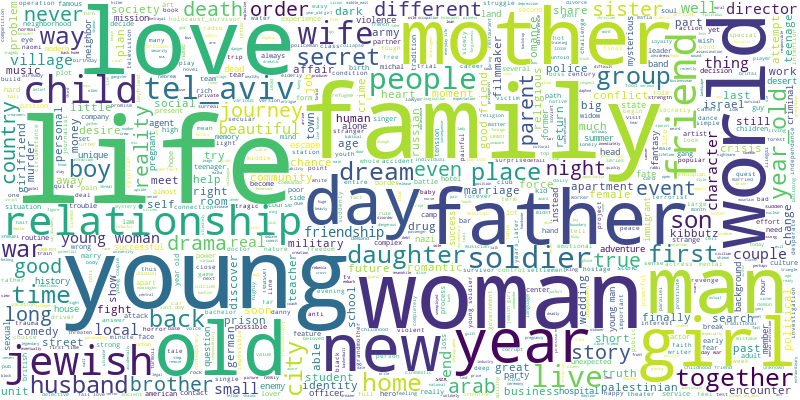

In [10]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=800,
    height=400)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Topic Modeling - Latent Dirichlet Allocation

Build The Topic Model

In [13]:
def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def allocate_topics(i, lda_model):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return max(x, key=itemgetter(1))[0]

In [14]:
num_topics = 10
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)
lda_model.save('lda_model')

lda_model.print_topics()

[(0,
  '0.010*"daughter" + 0.010*"young" + 0.009*"soldier" + 0.009*"man" + 0.009*"back" + 0.008*"family" + 0.007*"village" + 0.007*"life" + 0.007*"woman" + 0.007*"love"'),
 (1,
  '0.018*"life" + 0.015*"young" + 0.012*"love" + 0.010*"woman" + 0.009*"girl" + 0.008*"wife" + 0.007*"war" + 0.007*"old" + 0.007*"world" + 0.006*"new"'),
 (2,
  '0.018*"life" + 0.014*"love" + 0.012*"year" + 0.008*"old" + 0.007*"family" + 0.006*"man" + 0.006*"friend" + 0.006*"jewish" + 0.006*"mother" + 0.006*"woman"'),
 (3,
  '0.026*"woman" + 0.014*"young" + 0.011*"life" + 0.011*"tel_aviv" + 0.009*"group" + 0.007*"boy" + 0.007*"together" + 0.006*"world" + 0.006*"live" + 0.006*"year_old"'),
 (4,
  '0.012*"life" + 0.009*"family" + 0.009*"young" + 0.008*"jewish" + 0.007*"old" + 0.007*"love" + 0.007*"mother" + 0.006*"year" + 0.006*"child" + 0.006*"world"'),
 (5,
  '0.010*"young" + 0.010*"girl" + 0.009*"life" + 0.009*"first" + 0.008*"man" + 0.007*"time" + 0.006*"friend" + 0.006*"woman" + 0.005*"day" + 0.005*"new"'),
 

### Evaluation

In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

NameError: ignored

Assign Dominant Topic to each record

In [15]:
ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x, lda_model))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

del ready_data['i']
ready_data

Pandas Apply:   0%|          | 0/1061 [00:00<?, ?it/s]

,Unnamed: 0,Title,Year,Genre,Synopsis,IMDb id,Synopsis_lemmatized,Synopsis_preprocessed,Synopsis_topic
0,0,The Lost Daughter,2021,"Comedy, Drama",A young Israeli man absconds to Paris to flee ...,9100054,"[young, man, nationality]",young man nationality,6
1,1,A Story of David,1960,Drama,A woman's beach vacation takes a dark turn whe...,54342,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past,0
2,2,Rumpelstiltskin,1987,Drama,King Saul of Israel is jealous of the fame and...,93891,"[adoration, long, ago, victory, army, attempt,...",adoration long ago victory army attempt good p...,5
3,3,Bloomfield,1970,Drama,"Secrets, lies, surprises and more are explored...",68694,"[secret, lie, surprise, rich, selection, short]",secret lie surprise rich selection short,4
4,4,Synonymes,2019,"Drama, Sport",Eitan is yesterday's football star waiting for...,7016254,"[tomorrow, man, gut, prospect, new, profession...",tomorrow man gut prospect new profession woman...,3
...,...,...,...,...,...,...,...,...,...
1056,1459,Savage the Man,2017,Comedy,BlackSmile Challenging Himself To Create A 49 ...,6047312,"[blacksmile, minute, full, youtube, content]",blacksmile minute full youtube content,5
1057,1460,Visa,2013,"Comedy, Drama",A sham marriage for the sake of a UK residence...,3002628,"[marriage, sake, partnership, man, british, wo...",marriage sake partnership man british woman al...,0
1058,1465,The Glow of Heavens,2012,Drama,The story of a young soldier in the Israeli ar...,2931934,"[young, soldier, army, people, home, land, dee...",young soldier army people home land deep belief,8
1059,1468,Alenbi Romance,2005,"Drama, Romance","""All of those romantic movies are always in fo...",808145,"[romantic, always, foreign, city, always, easy...",romantic always foreign city always easy hard ...,3


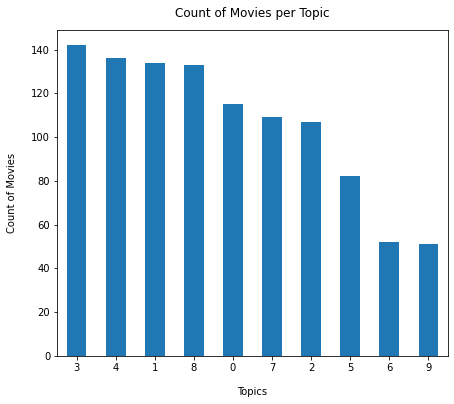

In [16]:
from numpy.lib.function_base import average
import statistics

# ready_data = ready_data[]

ready_data[f'{source}_topic'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("Count of Movies per Topic", y=1.02);

AVG Movies age per Topic

In [1]:

ready_data = ready_data.sort_values(by=[f'{source}_topic'])
test = ready_data.groupby(f'{source}_topic')['Year'].mean()
test.plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("AVG year per topic", y=1.02);

NameError: ignored

### Visualize Topics


Word Clouds of Top N Keywords in Each Topic

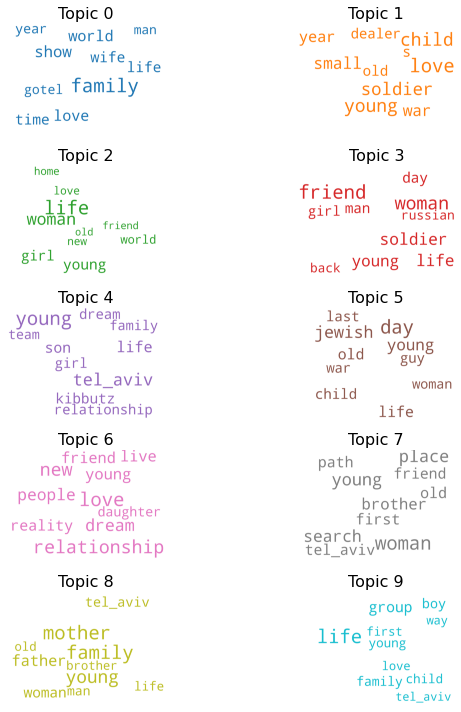

In [17]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.039696  0.113849       1        1  17.831574
8      0.108691  0.065763       2        1  14.488146
9      0.025239  0.039765       3        1  10.764160
3      0.074012 -0.056357       4        1   9.623775
0     -0.155564 -0.057061       5        1   9.120870
6     -0.047014  0.094831       6        1   9.039335
4      0.000514 -0.005261       7        1   8.474899
5      0.068256 -0.089466       8        1   7.933415
1      0.009967 -0.045607       9        1   7.057859
7     -0.044406 -0.060457      10        1   5.665968, topic_info=         Term       Freq       Total Category  logprob  loglift
162    mother  78.000000   78.000000  Default  30.0000  30.0000
78    brother  33.000000   33.000000  Default  29.0000  29.0000
52   tel_aviv  74.000000   74.000000  Default  28.0000  28.0000
154     child  64.000000   64.000000  Default  27.0000  27.0000
457   soldier  58.000000   58.000000  Default  26.0000  26.0000
..        ...        ...         ...      ...      ...      ...
101       end   3.928184   28.387072  Topic10  -5.5885   0.8929
249      year   4.329177   85.180171  Topic10  -5.4913  -0.1087
65       life   4.637641  206.492805  Topic10  -5.4225  -0.9254
322    family   4.481714  136.219811  Topic10  -5.4567  -0.5436
15     people   4.143340   60.084089  Topic10  -5.5352   0.1964

[741 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
150       3  0.166352     able
150       4  0.166352     able
150       7  0.083176     able
150       8  0.415879     able
150      10  0.166352     able
...     ...       ...      ...
4294      1  0.824773     yuda
4240      8  0.839985     zany
4486      6  0.732167   zodiac
4233      3  0.727345  zuaratz
4331      7  0.929848    zurim

[1508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 10, 4, 1, 7, 5, 6, 2, 8])

Word Counts of Topic Keywords

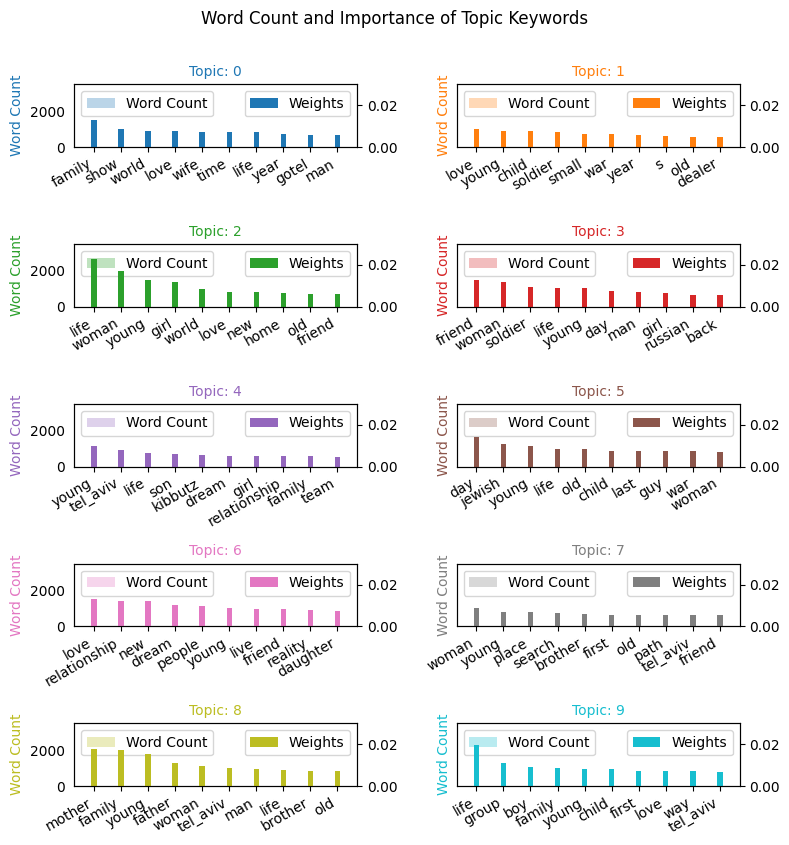

In [19]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in ready_data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(8,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=12, y=1.05)    
plt.show()